# Multi-qubit: GHZ phase estimation
In this example, we define a circuit to prepare a GHZ state. This state, ubiquitous in quantum information processing tasks, is highly entangled; and in the context of quantum metrology, saturates the Heisenberg limit.

In [ ]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import seaborn as sns
import ultraplot as uplt
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import SharedGate, Wire
from squint.ops.dv import Conditional, DiscreteVariableState, HGate, RZGate, XGate
from squint.simulator.tn import Simulator

In [ ]:
n = 3  # number of qubits
wires = [Wire(dim=2, idx=i) for i in range(n)]

circuit = Circuit()
for w in wires:
    circuit.add(DiscreteVariableState(wires=(w,), n=(0,)))

circuit.add(HGate(wires=(wires[0],)))
for i in range(n - 1):
    circuit.add(Conditional(gate=XGate, wires=(wires[i], wires[i + 1])))

circuit.add(
    SharedGate(op=RZGate(wires=(wires[0],), phi=0.0 * jnp.pi), wires=tuple(wires[1:])),
    "phase",
)

for w in wires:
    circuit.add(HGate(wires=(w,)))

pprint(circuit)

In [ ]:
params, static = eqx.partition(circuit, eqx.is_inexact_array)
sim = Simulator.compile(static, params, optimize="greedy")

In [13]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(lambda pytree: pytree.ops["phase"].op.phi, params, phis)

probs = jax.vmap(sim.probabilities.forward)(params)
grads = jax.vmap(sim.probabilities.grad)(params).ops["phase"].op.phi
qfims = jax.vmap(sim.amplitudes.qfim)(params)
cfims = jax.vmap(sim.probabilities.cfim)(params)

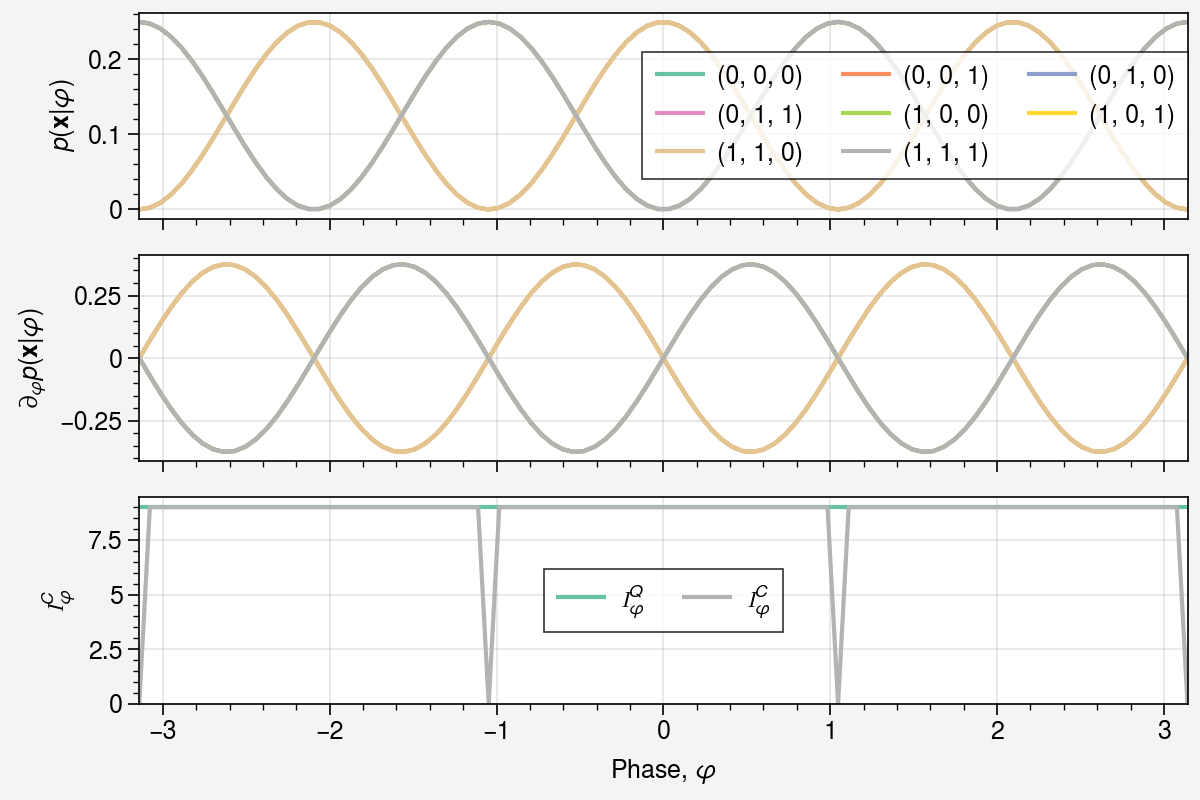

In [25]:
colors = sns.color_palette("Set2", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = uplt.subplots(nrows=3, figsize=(6, 4), sharey=False)

for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])

    axs[1].plot(phis, grads[:, *idx], label=f"{idx}", color=colors[i])
axs[0].legend()
axs[0].set(ylabel=r"$p(\mathbf{x} | \varphi)$")
axs[1].set(ylabel=r"$\partial_{\varphi} p(\mathbf{x} | \varphi)$")

axs[2].plot(phis, qfims.squeeze(), color=colors[0], label=r"$\mathcal{I}_\varphi^Q$")
axs[2].plot(phis, cfims.squeeze(), color=colors[-1], label=r"$\mathcal{I}_\varphi^C$")
axs[2].set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)
axs[2].legend();